In [68]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from model_params import RISK_FREE_RATE

In [65]:
def fetch_log_returns(start: str, end: str,
                      tickers: str = '^GSPC ^FTSE ^N225 ^GDAXI ^IBEX')\
        -> pd.DataFrame:
    """Downloads daily price data from Yahoo finance for five different
    stock indeces. Picks the closing daily price, keeps only bussiness days,
    fills the blank days with the previous value, computes the log returns
    and drops NaNs, if any.

    Args:
        start (str): starting data in format YYYY-MM-DD
        end (str): ending data in format YYYY-MM-DD

    Returns:
        pd.DataFrame: each column must correspond to the log daily returns
        of each asset.
    """
    raw_data = yf.download(tickers=tickers, start=start,
                           end=end, group_by='ticker',
                           auto_adjust=True)
    df_comp = pd.DataFrame(raw_data.copy())
    # Pick data from the first day to the last one
    df_comp = df_comp.iloc[1:]

    #  Take the closing prices
    df_comp['sp500'] = df_comp['^GSPC'].Close[:]
    df_comp['dax'] = df_comp['^GDAXI'].Close[:]
    df_comp['ftse'] = df_comp['^FTSE'].Close[:]
    df_comp['nikkei'] = df_comp['^N225'].Close[:]
    df_comp['ibex'] = df_comp['^IBEX'].Close[:]

    # Remove columns (we have renamed them)
    del df_comp['^GSPC'], df_comp['^GDAXI'], df_comp['^FTSE'], \
        df_comp['^N225'], df_comp['^IBEX']
    # Only keeping bussiness days as the stock market is closed on weekends
    price_data_frame = df_comp.asfreq('b')

    # Forward fill: fill empty with last value
    price_data_frame = df_comp.ffill()
    price_data_frame = price_data_frame[1:]

    log_return = np.log(price_data_frame/price_data_frame.shift(1))
    log_return.columns = [c[0] for c in log_return.columns]
    return log_return.dropna()

In [108]:
training_dataset = fetch_log_returns(start = '1995-01-01', end ='2005-12-31')

[*********************100%***********************]  5 of 5 completed


In [109]:
training_dataset.head()

,sp500,dax,ftse,nikkei,ibex
Date,,,,,
1995-01-05 00:00:00+00:00,-0.000803,-0.010397,-0.006345,-0.003457,-0.019565
1995-01-06 00:00:00+00:00,0.000738,0.003280,0.010726,-0.004939,0.000000
1995-01-09 00:00:00+00:00,0.000326,-0.002330,-0.003006,-0.003826,-0.014346
1995-01-10 00:00:00+00:00,0.001843,0.004213,0.001504,0.002903,-0.005274
1995-01-11 00:00:00+00:00,-0.000043,-0.000155,-0.003601,0.002408,-0.010125


In [127]:

def monte_carlo_sharpe_ratio(returns, num_simulations=10000, risk_free_rate=RISK_FREE_RATE):
    # Calculate mean returns and covariance matrix
    assets = returns.columns.tolist()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Number of assets
    num_assets = len(returns.columns)
    
    # Initialize array to store Sharpe ratios
    sharpe_ratios = np.zeros(num_simulations)
    all_weights = np.zeros((num_simulations, num_assets))
    best_weights = np.zeros(num_assets)
    best_sharpe = -np.inf
    for i in range(num_simulations):

        # Calculate the weighted sum of returns
        # Generate random weights
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)  # Normalize to sum to 1
        all_weights[i] = weights
        # Calculate portfolio return
        portfolio_return = np.dot(weights, mean_returns)

        # Calculate annualized return (assuming 252 trading days in a year)
        annualized_return = portfolio_return * 252

        # Calculate portfolio variance
        portfolio_variance = np.dot(weights, np.dot(cov_matrix, weights))

        # Calculate annualized volatility (assuming daily returns and 252 trading days)
        annualized_volatility = np.sqrt(portfolio_variance) * np.sqrt(252)

        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
        sharpe_ratios[i] = sharpe_ratio
        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_weights = weights

    # Calculate mean Sharpe ratio
    mean_sharpe = np.mean(sharpe_ratios)
    
    # Find weights that produce the Sharpe ratio closest to the mean
    closest_index = np.argmin(np.abs(sharpe_ratios - mean_sharpe))
    average_weights = all_weights[closest_index]

    return sharpe_ratios, best_weights, best_sharpe, average_weights, mean_sharpe

# Run Monte Carlo simulation
sharpe_ratios, weights, best_sharpe, average_weights, mean_sharpe = monte_carlo_sharpe_ratio(training_dataset, 20000)

# Calculate statistics
mean_sharpe = np.mean(sharpe_ratios)
median_sharpe = np.median(sharpe_ratios)
max_sharpe = np.max(sharpe_ratios)
min_sharpe = np.min(sharpe_ratios)

print(f"Mean Sharpe Ratio: {mean_sharpe:.4f}")
print(f"Median Sharpe Ratio: {median_sharpe:.4f}")
print(f"Max Sharpe Ratio: {max_sharpe:.4f}")
print(f"Min Sharpe Ratio: {min_sharpe:.4f}")


Mean Sharpe Ratio: 0.2149
Median Sharpe Ratio: 0.2203
Max Sharpe Ratio: 0.4111
Min Sharpe Ratio: -0.1940


In [128]:
weights

array([4.84511509e-01, 1.61096973e-02, 5.27550324e-02, 1.40948040e-04,
       4.46482813e-01])

In [129]:
best_sharpe

np.float64(0.4110639975951253)

We have run a Monte Carlo simulation to find the best sharpe ratio and the weights that produce it. We have run $20000$ simulations. During each simulation we have generated random weights and computed the sharpe ratio. The best sharp ratio found was $0.4110639975951253$ with the following weights:

$\left[\begin{array}{ccccc}
0.484511509 & 0.016109697 & 0.052755032 & 0.000140948 & 0.446482813
\end{array}\right]$ 

In the histogram below, we have shown the Sharpe scores obtained during the Monte Carlo simulation. The results are consistent with the outcome of the quantum experiments.


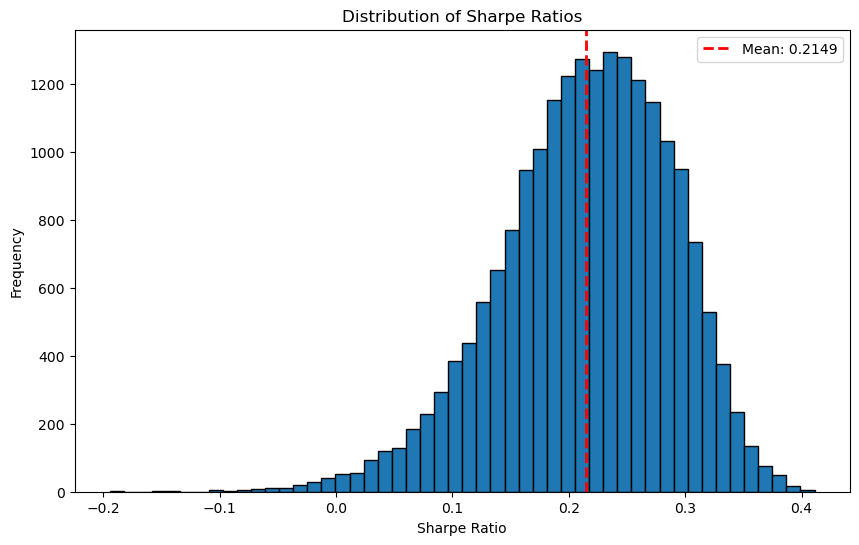

In [130]:
plt.figure(figsize=(10, 6))
plt.hist(sharpe_ratios, bins=50, edgecolor='black')
plt.title('Distribution of Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')
plt.axvline(mean_sharpe, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_sharpe:.4f}')
plt.legend()
plt.show()